# Long Run Portfolio Choice

This notebook summarizes how the distribution of returns is affected by the investment horizon.

## Load Packages and Extra Functions

In [1]:
using Printf, LinearAlgebra, Distributions

include("src/printmat.jl")
include("src/lag.jl");

In [2]:
using Plots, LaTeXStrings
default(size = (480,320),fmt = :png)

# Distribution of Long-Run Returns in the iid Case

If the excess log return over one period $r^e$ is iid $N(\mu,\sigma^2)$, then excess log return over $q$ periods is $z^e_q$ is $N(q\mu,q\sigma^2)$. We use this result to draw the density function and to calculate the probability of $z^e_q < 0$.


### A Remark on the Code

The Distributions.jl package defines a normal distribution by `Normal(μ,σ)`, that is, using the standard deviation (not the variance) as the 2nd argument. For horizon `q` we thus use `Normal(q*μ,sqrt(q)*σ)`.

## Pdfs of Long-Run Returns (for Different Horizons)

In [3]:
zᵉ_range = range(-50,100,length=101)
μᵉ = 0.06*100                                   #average excess return of annual data
σ  = 0.19*100                                   #std of annual data

pdf_1y  = pdf.(Normal(μᵉ,σ),zᵉ_range)               #pdf of 1-year returns
pdf_10y = pdf.(Normal(10*μᵉ,sqrt(10)*σ),zᵉ_range);  #pdf of 10-year returns

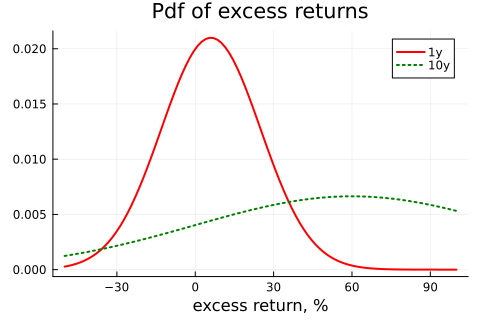

In [4]:
p1 = plot( zᵉ_range,[pdf_1y pdf_10y],
           linecolor = [:red :green],
           linestyle = [:solid :dot],
           linewidth = 2,
           label = ["1y" "10y"],
           title = "Pdf of excess returns",
           xlabel = "excess return, %" )
display(p1)

##    Prob(zᵉ < 0) for Different Horizons

### A Remark on the Code
code like `y = [exp(q) for q in 1:10]` creates a vector with 10 elements (`exp(1),exp(2)...`). It's a short form of a loop. In some cases, this is more conveniently writen as `exp.(1:10)`, but in other cases a loop works better (here it does since we have to change the distribution for each `q`).

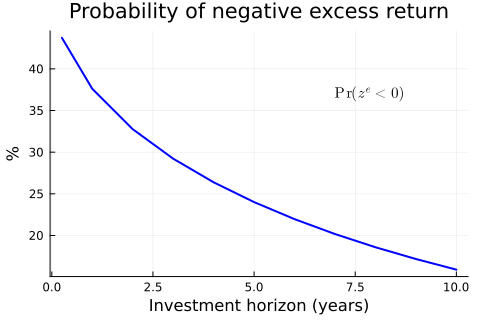

In [5]:
q_max         = 10      #longest horizon considered in the calculations
qM = vcat(0.25,1:q_max)
ProbNegReturn = [cdf(Normal(q*μᵉ,sqrt(q)*σ),0) for q in qM]   #Pr(z<=0) for different horizons

txt = L"\mathrm{Pr}(z^e<0)"
p1 = plot( qM,ProbNegReturn*100,
           linecolor = :blue,
           linewidth = 2,
           legend = false,
           title = "Probability of negative excess return",
           xlabel = "Investment horizon (years)",
           ylabel = "%",
           annotation = (7,37,text(txt,10,:left)) )
display(p1)

## E(zᵉ|zᵉ < 0) for Different Horizons

The `Distributions.jl` package has methods fot trunctated distributions. We calculate $\mathrm{E}(z^e|z^e<0)$ for horizon $q$ by using

```
mean(truncated(Normal(q*μᵉ,sqrt(q)*σ);upper=0)
```

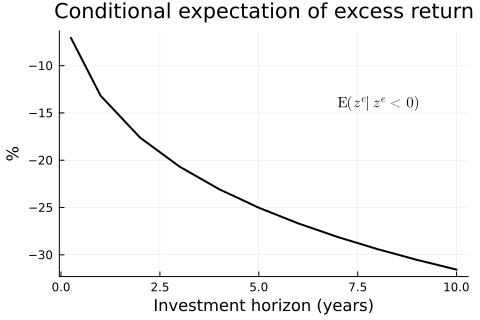

In [6]:
CondER = [mean(truncated(Normal(q*μᵉ,sqrt(q)*σ);upper=0)) for q in qM]

txt = L"\mathrm{E}(z^e|z^e<0)"
p1 = plot( qM,CondER,
           linecolor = :black,
           linewidth = 2,
           legend = false,
           title = "Conditional expectation of excess return",
           xlabel = "Investment horizon (years)",
           ylabel = "%",
           annotation = (7,-14,text(txt,10,:left)) )
display(p1)

# Mean-Variance Portfolio Choice

This section runs the time series model presented in the lecture notes. It therefore more code than usual


In [7]:
include("src/Var1IR.jl");   #impulse response of VAR(1), Cov(x) from MA(q)

In [8]:
"""
    xzModel3(ϕ,θ,T)
"""
function xzModel3(ϕ,θ,T)
  A = [0 1;
       0 ϕ]
  B = [1 0;
       θ 1]
  C = VAR1IR(A,T,B)
  r = C[1,:,:]'
  z = C[2,:,:]'
  return r, z
end

"""
    xzModel3Cov(ϕ,θ,σᵤ,σ_eta,q)

Calculate conditional variance-covariance matrix of q future
returns (r_1,r_2,...,r_q) by first finding the MA representation
and then apply MACov.
"""
function xzModel3Cov(ϕ,θ,σᵤ,σ_eta,q)

  (r_IR,z_IR) = xzModel3(ϕ,θ,q+10)
  r_IR .*= [σᵤ σ_eta]
  z_IR .*= [σᵤ σ_eta]

  k = 2                                       #no. variables
  C = fill(NaN,q,k,q)
  for t in 1:q
    r_t = vcat(zeros(q-t,k),r_IR[1:t,:])      #t=1: [zeros(9,2);[1 0]]
    C[t,:,:] = r_t'                           #t=2: [zeros(8,2);[-0.5 1];[1 0]]
  end

  CovM = MACov(C,1.0I(k))

  return CovM, r_IR, C

end

xzModel3Cov

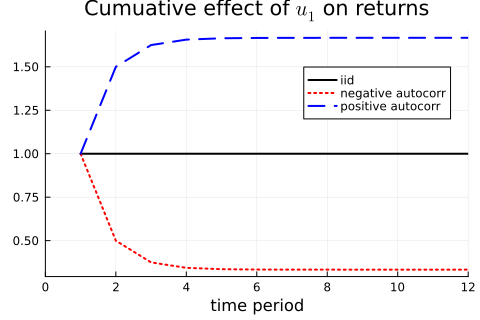

In [9]:
(ϕ,σᵤ,σ_eta,T) = (0.25,0.05,0.02,12)

(r_0,z_0) = xzModel3(0,0,T)
(r_m,z_m) = xzModel3(ϕ,-0.5,T)
(r_p,z_p) = xzModel3(ϕ,0.5,T)

p1 = plot( 1:T,cumsum([r_0[:,1] r_m[:,1] r_p[:,1]],dims=1),
           xlims = (0,T),
           linestyle = [:solid :dot :dash],
           linecolor = [:black :red :blue],
           linewidth = 2,
           label = ["iid" "negative autocorr" "positive autocorr"],
           legend = (0.7,0.8),
           title = L"Cumuative effect of $u_1$ on returns",
           xlabel = "time period" )
display(p1)

In [10]:
qM = 1:T

Var_q = fill(NaN,T,3)
for q in qM
  local CovM_m, CovM_0, CovM_p
  CovM_0, = xzModel3Cov(ϕ,0,σᵤ,0,q)                    #iid
  CovM_m, = xzModel3Cov(ϕ,-0.5,σᵤ,σ_eta,q)             #reversal
  CovM_p, = xzModel3Cov(ϕ,0.5,σᵤ,σ_eta,q)              #momentum
  Var_q[q,:] = [sum(CovM_0) sum(CovM_m) sum(CovM_p)]   #var(r₁+r₂+...+r_q)
end
printmat(Var_q*10_000);

    25.000    25.000    25.000
    50.000    35.250    85.250
    75.000    45.016   157.516
   100.000    54.860   232.985
   125.000    64.737   309.269
   150.000    74.623   385.756
   175.000    84.511   462.295
   200.000    94.400   538.846
   225.000   104.289   615.400
   250.000   114.178   691.956
   275.000   124.067   768.511
   300.000   133.956   845.067



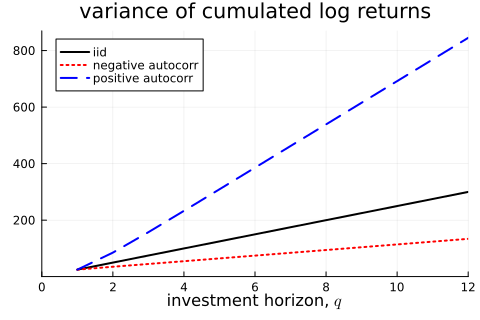

In [11]:
p1 = plot( qM,Var_q*10_000,
           xlims = (0,T),
           linestyle = [:solid :dot :dash],
           linecolor = [:black :red :blue],
           linewidth = 2,
           title = "variance of cumulated log returns",
           label = ["iid" "negative autocorr" "positive autocorr"],
           xlabel = L"investment horizon, $q$" )

In [12]:
"""
    vWeight(μᵉ,σ²,k)

Optimal portfolio weight on the risky asset, so (1-v) is in the risk-free asset

"""
vWeight(μᵉ,σ²,k) = μᵉ/((1+k)*σ²) + 1/(2*(1+k))

vWeight

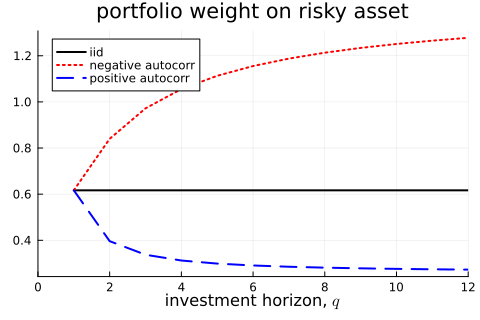

In [13]:
(μᵉ,k) = (0.8/100,5)
v_q = vWeight.(μᵉ.*qM,Var_q,k)

p1 = plot( qM,v_q,
           xlims = (0,T),
           linestyle = [:solid :dot :dash],
           linecolor = [:black :red :blue],
           linewidth = 2,
           title = "portfolio weight on risky asset",
           label = ["iid" "negative autocorr" "positive autocorr"],
           xlabel = L"investment horizon, $q$" )